In [3]:
# For importing utils
import sys
sys.path.append("..")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
from utils import PERTURBATIONS

/nlp/scr/kallini/miniconda3/envs/mission-impossible-2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def get_surprisal_differences(perturbation, seed, ckpt, pos_encodings=True):

    # Load surprisal DataFrame
    surprisals_path = "hop_surprisal_results/{}_100M{}/randinit_seed{}.csv"
    nps = "" if pos_encodings else "_no_positional_encodings"
    surprisal_df = pd.read_csv(surprisals_path.format(perturbation, nps, seed))
    
    # Get summary stats for suprisal differences
    marker_token_surprisals = surprisal_df[f"Marker Token Surprisals (ckpt {ckpt})"]
    nomarker_token_surprisals = surprisal_df[f"No Marker Token Surprisals (ckpt {ckpt})"]
    differences = nomarker_token_surprisals - marker_token_surprisals
    avg_differences = differences.mean()

    return avg_differences

def get_summary_stats(l):
    # Calculate confidence interval using t-distribution
    mean = np.mean(l)
    sem = stats.sem(l)
    ci_lower, ci_upper = stats.t.interval(0.95, df=len(l)-1, loc=mean, scale=sem)
    return mean, (ci_upper - ci_lower) / 2
    

In [ ]:
def plot_surprisal_differences(ax, seeds, ckpt, colors, hatches, pos_encodings):

    hop_control_seeds = []
    hop_tokens4_seeds = []
    hop_words4_seeds = []
    for seed in seeds:
        # Get summary stats for each hop model
        avg_hop_control = get_surprisal_differences("hop_control", seed, ckpt, pos_encodings)
        avg_hop_tokens4 = get_surprisal_differences("hop_tokens4", seed, ckpt, pos_encodings)
        avg_hop_words4 = get_surprisal_differences("hop_words4", seed, ckpt, pos_encodings)

        # Append results
        hop_control_seeds.append(avg_hop_control)
        hop_tokens4_seeds.append(avg_hop_tokens4)
        hop_words4_seeds.append(avg_hop_words4)

    if len(seeds) > 1:
        # Prepare data to plot
        summary_stats = [
            get_summary_stats(hop_control_seeds),
            get_summary_stats(hop_tokens4_seeds),
            get_summary_stats(hop_words4_seeds)
        ]
    else:
        summary_stats = [
            (hop_control_seeds[0], 0),
            (hop_tokens4_seeds[0], 0),
            (hop_words4_seeds[0], 0),
        ]

    x = np.arange(3)  # label locations
    width = 0.8  # width of the bars

    # Iterate over pos / no pos groups
    for i, (avg, err) in enumerate(summary_stats):
        # Iterate over models and plot bars
        color = colors[i]
        hatch = hatches[i]
        ax.bar(x[i], avg, width, yerr=err, label=None,
                color=color, hatch=hatch, edgecolor="w", zorder=2)

    ax.set_xticks([])
    ax.grid(zorder=0, color="lightgray")
    ax.set_title(f"{ckpt} Steps")


def plot_surprisal_differences_checkpoints(seeds, checkpoints, pos_encodings=True):

    # Colors patterns for bars
    color1=PERTURBATIONS["hop_control"]["color"]
    color2=PERTURBATIONS["hop_tokens4"]["color"]
    color3=PERTURBATIONS["hop_words4"]["color"]
    colors = [color1, color2, color3]

    hatch1 = ''
    hatch2 = '///'
    hatch3 = '..'
    hatches = [hatch1, hatch2, hatch3]

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharey=True)
    axes_flat = axs.flatten()

    # Call individual plot function with different parameters for each subplot
    for i, checkpoint in enumerate(checkpoints):
        plot_surprisal_differences(
            axes_flat[i], seeds, checkpoint, colors, hatches, pos_encodings)

    legend_elements = [Patch(facecolor=color1, hatch=hatch1,
                             edgecolor="w", label='NoHop'),
                       Patch(facecolor=color2, hatch=hatch2,
                             edgecolor="w", label='TokenHop'),
                        Patch(facecolor=color3, hatch=hatch3,
                              edgecolor="w", label='WordHop')]
    fig.legend(handles=legend_elements, ncol=3, loc="center",
                bbox_to_anchor=(0.55, 0), frameon=False)
        
    fig.supylabel("Surprisal Difference", fontsize=12, x=0.04)

    # Adjust layout and show plot
    plt.tight_layout()

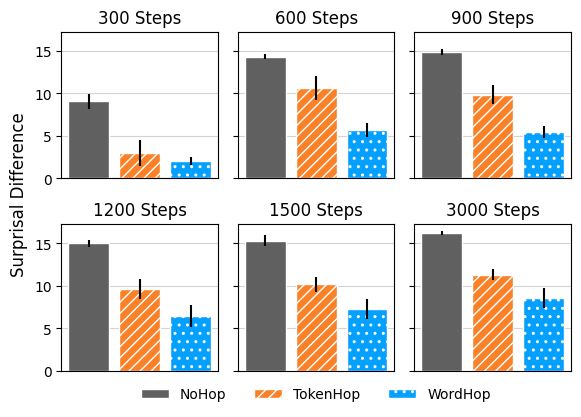

In [5]:
CHECKPOINTS = [300, 600, 900, 1200, 1500, 3000]
SEEDS = [0, 14, 41, 53, 96]

plot_surprisal_differences_checkpoints(seeds=SEEDS, checkpoints=CHECKPOINTS)
plt.savefig(f"figures/hop_surprisals.pdf", format="pdf", bbox_inches="tight")

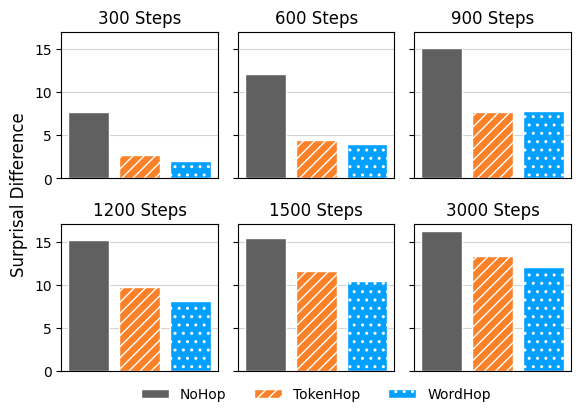

In [6]:
plot_surprisal_differences_checkpoints(seeds=[53], checkpoints=CHECKPOINTS, pos_encodings=False)
plt.savefig(f"figures/hop_surprisals_no_pos_encodings.pdf", format="pdf", bbox_inches="tight")

## New Models

In [5]:
def get_surprisal_differences(perturbation, seed, ckpt, model):

    # Load surprisal DataFrame
    surprisals_path = "hop_surprisal_results/{}_100M/{}_seed{}.csv"
    surprisal_df = pd.read_csv(surprisals_path.format(perturbation, model, seed))
    
    # Get summary stats for suprisal differences
    marker_token_surprisals = surprisal_df[f"Marker Token Surprisals (ckpt {ckpt})"]
    nomarker_token_surprisals = surprisal_df[f"No Marker Token Surprisals (ckpt {ckpt})"]
    differences = nomarker_token_surprisals - marker_token_surprisals
    avg_differences = differences.mean()

    return avg_differences

def get_summary_stats(l):
    # Calculate confidence interval using t-distribution
    mean = np.mean(l)
    sem = stats.sem(l)
    ci_lower, ci_upper = stats.t.interval(0.95, df=len(l)-1, loc=mean, scale=sem)
    return mean, (ci_upper - ci_lower) / 2
    

In [7]:
def plot_surprisal_differences(ax, seeds, ckpt, colors, hatches, model_type):

    hop_control_seeds = []
    hop_tokens4_seeds = []
    hop_words4_seeds = []
    for seed in seeds:
        # (perturbation, seed, ckpt, model)
        # Get summary stats for each hop model
        avg_hop_control = get_surprisal_differences("hop_control", seed, ckpt, "control_hop_"+model_type)
        avg_hop_tokens4 = get_surprisal_differences("hop_tokens4", seed, ckpt, "token_hop_"+model_type)
        avg_hop_words4 = get_surprisal_differences("hop_words4", seed, ckpt, "word_hop_"+model_type)

        # Append results
        hop_control_seeds.append(avg_hop_control)
        hop_tokens4_seeds.append(avg_hop_tokens4)
        hop_words4_seeds.append(avg_hop_words4)

    if len(seeds) > 1:
        # Prepare data to plot
        summary_stats = [
            get_summary_stats(hop_control_seeds),
            get_summary_stats(hop_tokens4_seeds),
            get_summary_stats(hop_words4_seeds)
        ]
    else:
        summary_stats = [
            (hop_control_seeds[0], 0),
            (hop_tokens4_seeds[0], 0),
            (hop_words4_seeds[0], 0),
        ]

    x = np.arange(3)  # label locations
    width = 0.8  # width of the bars

    # Iterate over pos / no pos groups
    for i, (avg, err) in enumerate(summary_stats):
        # Iterate over models and plot bars
        color = colors[i]
        hatch = hatches[i]
        ax.bar(x[i], avg, width, yerr=err, label=None,
                color=color, hatch=hatch, edgecolor="w", zorder=2)

    ax.set_xticks([])
    ax.grid(zorder=0, color="lightgray")
    ax.set_title(f"{ckpt} Steps")


def plot_surprisal_differences_checkpoints(seeds, checkpoints, model_type):

    # Colors patterns for bars
    color1=PERTURBATIONS["hop_control"]["color"]
    color2=PERTURBATIONS["hop_tokens4"]["color"]
    color3=PERTURBATIONS["hop_words4"]["color"]
    colors = [color1, color2, color3]

    hatch1 = ''
    hatch2 = '///'
    hatch3 = '..'
    hatches = [hatch1, hatch2, hatch3]

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharey=True)
    axes_flat = axs.flatten()

    # Call individual plot function with different parameters for each subplot
    for i, checkpoint in enumerate(checkpoints):
        plot_surprisal_differences(
            axes_flat[i], seeds, checkpoint, colors, hatches, model_type)

    legend_elements = [Patch(facecolor=color1, hatch=hatch1,
                             edgecolor="w", label='NoHop'),
                       Patch(facecolor=color2, hatch=hatch2,
                             edgecolor="w", label='TokenHop'),
                        Patch(facecolor=color3, hatch=hatch3,
                              edgecolor="w", label='WordHop')]
    fig.legend(handles=legend_elements, ncol=3, loc="center",
                bbox_to_anchor=(0.55, 0), frameon=False)
        
    fig.supylabel("Surprisal Difference", fontsize=12, x=0.04)

    # Adjust layout and show plot
    plt.tight_layout()

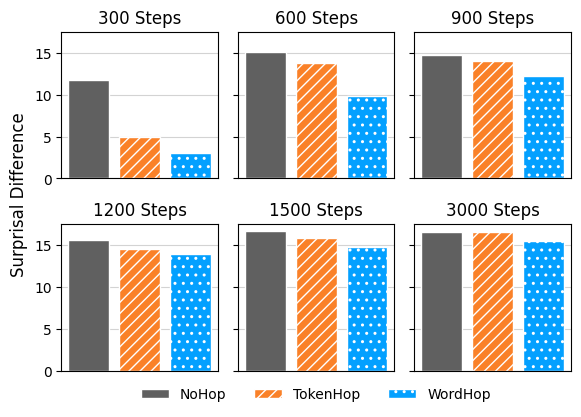

In [9]:
CHECKPOINTS = [300, 600, 900, 1200, 1500, 3000]
plot_surprisal_differences_checkpoints(seeds=[53], checkpoints=CHECKPOINTS, model_type="gpt2")

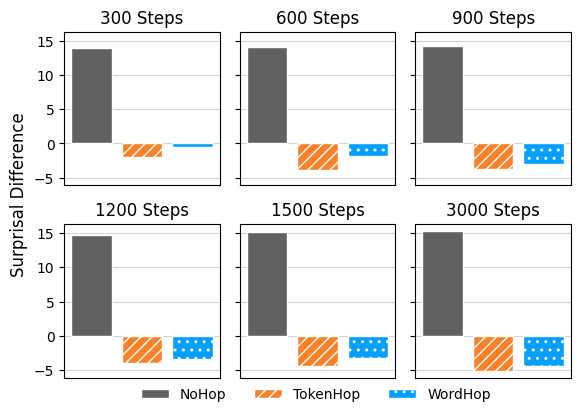

In [10]:
plot_surprisal_differences_checkpoints(seeds=[53], checkpoints=CHECKPOINTS, model_type="alibi")

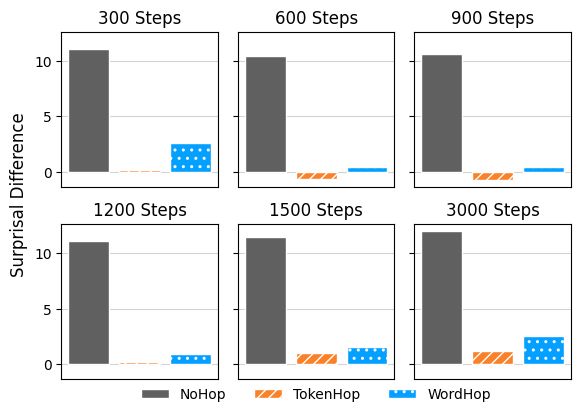

In [11]:
plot_surprisal_differences_checkpoints(seeds=[53], checkpoints=CHECKPOINTS, model_type="geom_attn")